In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import itertools

import dataset_class_image
import torch_net_class

In [2]:
dataset_file_name = "mnist_train.csv"
df = pd.read_csv(dataset_file_name)
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
len(df)

60000

In [5]:
num_images = 10000
image_folder_name = "mnist"
image_file_path_list = []
try:
    os.mkdir(image_folder_name)
except FileExistsError:
    pass

image_labels = np.zeros(shape=(num_images))

for ex_i in range(0, num_images):
    label = df.iloc[ex_i,0]
    image_array = np.array(df.iloc[ex_i,1:])
    image_labels[ex_i] = float(np.array(df.iloc[ex_i,0]))
    image_len = int(np.sqrt(image_array.shape[0]))
    image_shape = (image_len,image_len)
    image = image_array.reshape(image_shape)
    image_file_path = image_folder_name + "/{}".format(ex_i)
    image_file_path_list.append(image_file_path)
    np.savetxt(image_file_path, image_array)
    
image_label_df = pd.DataFrame(image_labels, columns=["number"])
image_label_df.to_csv("mnist_labels.csv")


In [6]:
load_label_df = pd.read_csv("mnist_labels.csv")
load_label_df.head()


,Unnamed: 0,number
0,0,5.0
1,1,0.0
2,2,4.0
3,3,1.0
4,4,9.0


In [7]:
np.array(load_label_df.loc[[0],["number"]])

array([[5.]])

In [8]:
np.array(load_label_df["number"][1])

array(0.)

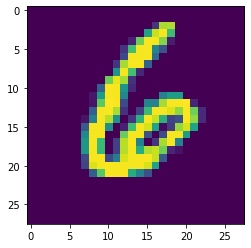

In [24]:
i = 13
image_file_path = image_file_path_list[i]
image_array = np.loadtxt(image_file_path)
image = image_array.reshape(image_shape)
plt.imshow(image)

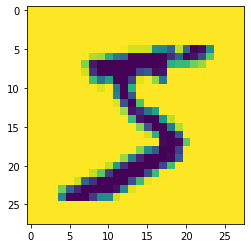

In [9]:
inv_image = 255-image
plt.imshow(inv_image)

new_shape = tuple([1] + list(inv_image.shape))

In [10]:
dual_image = np.concatenate((image.reshape(new_shape), inv_image.reshape(new_shape)))

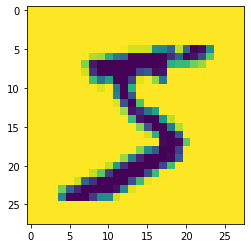

In [11]:
np.savetxt("dual_test_image", dual_image.reshape(-1))
loaded_dual_image = np.loadtxt("dual_test_image").reshape(tuple([2] + list(inv_image.shape)))
plt.imshow(loaded_dual_image[1])

In [12]:
#(1,28,28)
"""Code to visualize the convnet structure"""
"""How the layer sizes vary for given kernel sizes"""
input_shape = [1,28,28]
image_shape = input_shape[1:]
#print(image_shape)

#dimension of the image
image_d = len(image_shape)

#dimension of the kernels
#less or equal to image dimension
kernel_d = 3

#kernel sizes and number of channels for each layer
kernel_sizes = [7,7,7,7]
channels = [5,5]


#generate kernel shape array
kernel_shapes = []
for kernel_size in kernel_sizes:
    kernel_shape = [kernel_size]*kernel_d + [1]*(image_d - kernel_d)
    kernel_shapes.append(kernel_shape)

kernel_shapes = [(4,4),(4,4),(4,4),(4,4),(4,4)]

print(kernel_shapes)

#the size of the intermediate convoluted layer in the network
conv_sizes = []

#the first layer is the input = image shape
conv_sizes.append(image_shape)

for layer_i, kernel_shape in enumerate(kernel_shapes):
    #print(layer_i)
    #print(kernel_shape)
    
    #size of the intermediate convoluted layer
    new_image_size = []
    #product for all d: image_l - kernel_l + 1
    for d in range(0,image_d):
        #print(d)
        new_image_size.append(conv_sizes[-1][d] - kernel_shape[d] + 1)
    #print(new_image_size)
        
    conv_sizes.append(new_image_size)
    
print(conv_sizes)

[(4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]
[[28, 28], [25, 25], [22, 22], [19, 19], [16, 16], [13, 13]]


In [13]:
input_shape = [1,28,28]
net_struct = []
net_struct.append( {"type": nn.Conv2d, "layer_pars": {"in_channels": 1, "out_channels": 3, "kernel_size": (4,6), "bias": True}} )
net_struct.append( {"type": nn.Conv2d, "layer_pars": {"in_channels": 3, "out_channels": 6, "kernel_size": (3,6), "bias": True}} )
net_struct.append( {"type": nn.Conv2d, "layer_pars": {"in_channels": 6, "out_channels": 12, "kernel_size": (2,4), "bias": True}} )
#net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 22*22, "out_features": 10}, "bias": True, "act_func": "relu"} )

layer_sizes = []

def calc_layer_sizes(input_shape, net_struct):
    layer_sizes = [input_shape]
    
    for i in range(len(net_struct)):
        new_layer_size = []
        if net_struct[i]["type"] == nn.Linear:
            new_layer_size = net_struct[i]["layer_pars"]["out_features"]
            
        elif net_struct[i]["type"] == nn.Conv2d:
            
            kernel_shape = net_struct[i]["layer_pars"]["kernel_size"]
            new_layer_size = [layer_sizes[-1][d+1] - kernel_shape[d] + 1 for d in range(len(kernel_shape))]
            new_layer_size = [net_struct[i]["layer_pars"]["out_channels"]] + new_layer_size
        
        layer_sizes.append(new_layer_size)
    
    return layer_sizes

layer_sizes = calc_layer_sizes(input_shape, net_struct)
print(layer_sizes)

[[1, 28, 28], [3, 25, 23], [6, 23, 18], [12, 22, 15]]
